# SSD7 Inference Tutorial

This is a brief tutorial that shows how to use a trained SSD300 for inference on the Pascal VOC datasets. If you'd like more detailed explanations, please refer to [`ssd300_training.ipynb`](https://github.com/pierluigiferrari/ssd_keras/blob/master/ssd300_training.ipynb)

In [1]:
# Downgrade tensoflow
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
# Downgrade gast version 0.2.2
!pip install gast==0.2.2

  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=5ccfe41d29b3363cd947c79ad23c58565c1c29f705dd831cd66b2fed796d789c
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3


In [3]:
# Downgrade keras version 2.2.4
!pip install keras==2.2.4

     |████████████████████████████████| 317kB 3.7MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [4]:
# Upload the gdrive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
# Unzip the dataset
!unzip '/content/drive/My Drive/ssd_keras-master/Group-1-PersonDetectionFromTopView/Dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Dataset_CV/ImagesDir/2_329_948_165304-795795.jpg  
  inflating: Dataset_CV/ImagesDir/2_329_948_165305-665665.jpg  
  inflating: Dataset_CV/ImagesDir/2_329_948_165306-343343.jpg  
  inflating: Dataset_CV/ImagesDir/2_329_948_165306-805805.jpg  
  inflating: Dataset_CV/ImagesDir/2_329_948_165307-525525.jpg  
  inflating: Dataset_CV/ImagesDir/2_329_948_165308-239239.jpg  
  inflating: Dataset_CV/ImagesDir/2_329_948_165309-104104.jpg  
  inflating: Dataset_CV/ImagesDir/2_329_948_165310-165165.jpg  
  inflating: Dataset_CV/ImagesDir/2_329_948_165310-726726.jpg  
  inflating: Dataset_CV/ImagesDir/2_329_949_144536-204204.jpg  
  inflating: Dataset_CV/ImagesDir/2_329_949_144536-539539.jpg  
  inflating: Dataset_CV/ImagesDir/2_329_949_144537-167167.jpg  
  inflating: Dataset_CV/ImagesDir/2_329_950_165311-335335.jpg  
  inflating: Dataset_CV/ImagesDir/2_329_950_165313-543543.jpg  
  inflating: Dataset_CV/ImagesDir/2_329_950_165315-03

In [6]:
# Enter in ssd_keras dir
%cd /content/drive/My Drive/ssd_keras-master/Group-1-PersonDetectionFromTopView

/content/drive/My Drive/ssd_keras-master/Group-1-PersonDetectionFromTopView


In [7]:
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from imageio import imread
import numpy as np
from matplotlib import pyplot as plt

from collections import namedtuple
import cv2

from models.keras_ssd7 import build_model
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast

from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize

%matplotlib inline

Using TensorFlow backend.


In [8]:
# Set the image size.
img_height = 480
img_width = 640

# Define the `Detection` object
Detection = namedtuple("Detection", ["image_path", "gt", "pred"])

## 1. Load a trained SSD

Either load a trained model or build a model and load trained weights into it. Since the HDF5 files I'm providing contain only the weights for the various SSD versions, not the complete models, you'll have to go with the latter option when using this implementation for the first time. You can then of course save the model and next time load the full model directly, without having to build it.

You can find the download links to all the trained model weights in the README.

### 1.1. Build the model and load trained weights into it

In [9]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = build_model(image_size=(img_height, img_width, 3),
                    n_classes=1,
                    mode='training',  # Change to inference for weights
                    l2_regularization=0.0005,
                    scales=[0.08, 0.16, 0.32, 0.64, 0.96],
                    aspect_ratios_global=[0.5, 1.0, 2.0],
                    aspect_ratios_per_layer=None,
                    two_boxes_for_ar1=True,
                    steps=None,
                    offsets=None,
                    clip_boxes=False,
                    variances=[1.0, 1.0, 1.0, 1.0],
                    normalize_coords=True,
                    subtract_mean=127.5,
                    divide_by_stddev=127.5)

# 2: Load the trained weights into the model.

# TODO: Set the path of the trained weights.
weights_path = '/content/drive/My Drive/ssd_keras_model/ssd7_epoch-35.h5'

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
















Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.


Or

### 1.2. Load a trained model

In [ ]:
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = '/content/drive/My Drive/ssd_keras_model/ssd7_cvdata_epoch-16_loss-1.0308_val_loss-0.8069.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,                                              
                                               'compute_loss': ssd_loss.compute_loss})
















Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.




## 2. Load some images

Load some images for which you'd like the model to make predictions.

In [ ]:
orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

# We'll only load one image in this example.
img_path = '/content/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/000008.jpg'

orig_images.append(imread(img_path))
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img) 
input_images.append(img)
input_images = np.array(input_images)

## 3. Make predictions

In [ ]:
y_pred = model.predict(input_images)

`y_pred` contains a fixed number of predictions per batch item (200 if you use the original model configuration), many of which are low-confidence predictions or dummy entries. We therefore need to apply a confidence threshold to filter out the bad predictions. Set this confidence threshold value how you see fit.

In [ ]:
confidence_threshold = 0.5

y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh[0])

Predicted boxes:

    class    conf  xmin    ymin    xmax    ymax
[[ 15.     1.   128.13   3.57 214.03 156.3 ]
 [  2.     0.68  21.96  72.   281.98 283.46]]


## 4. Visualize the predictions

We just resized the input image above and made predictions on the distorted image. We'd like to visualize the predictions on the image in its original size though, so below we'll transform the coordinates of the predicted boxes accordingly.

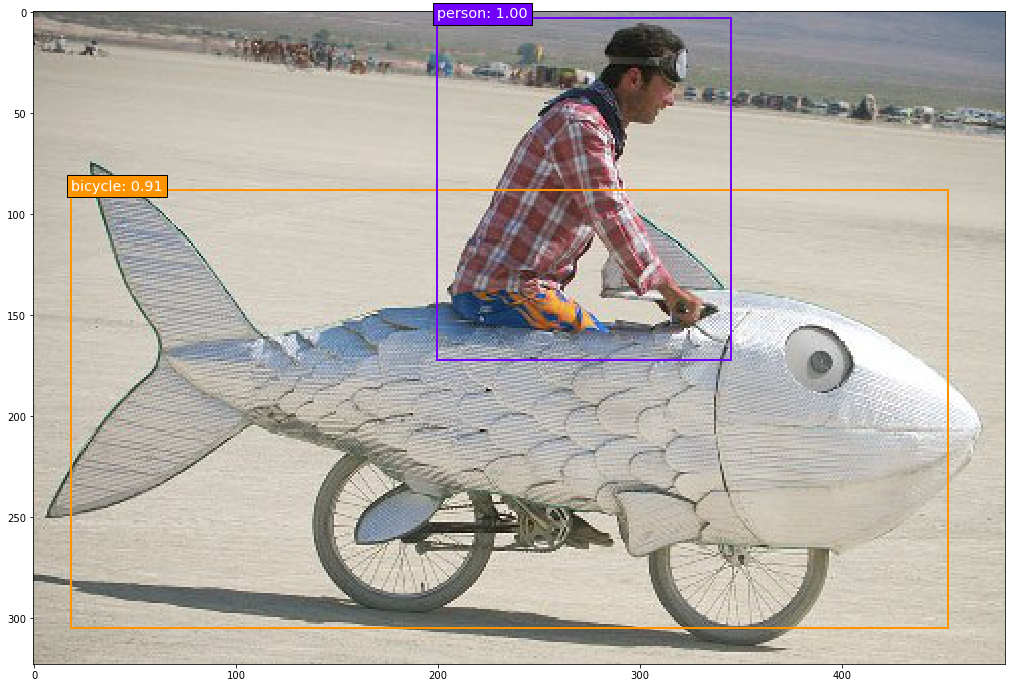

In [ ]:
# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['background', 'person']

plt.figure(figsize=(20,12))
plt.imshow(orig_images[0])

current_axis = plt.gca()

for box in y_pred_thresh[0]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[2] * orig_images[0].shape[1] / img_width
    ymin = box[3] * orig_images[0].shape[0] / img_height
    xmax = box[4] * orig_images[0].shape[1] / img_width
    ymax = box[5] * orig_images[0].shape[0] / img_height
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

## 5. Make predictions on Pascal VOC 2007 Test

Let's use a `DataGenerator` to make predictions on the Pascal VOC 2007 test dataset and visualize the predicted boxes alongside the ground truth boxes for comparison. Everything here is preset already, but if you'd like to learn more about the data generator and its capabilities, take a look at the detailed tutorial in [this](https://github.com/pierluigiferrari/data_generator_object_detection_2d) repository.

In [10]:
# Create a `BatchGenerator` instance and parse the Pascal VOC labels.

dataset = DataGenerator()

# TODO: Set the paths to the datasets here.

Dataset_CV_images_dir              = '/content/Dataset_CV/ImagesDir/'
Dataset_CV_annotations_dir         = '/content/Dataset_CV/AnnotationsDir/'
Dataset_CV_test_image_set_filename = '/content/Dataset_CV/ImageSet/test.txt'

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['background', 'person']

dataset.parse_xml(images_dirs=[Dataset_CV_images_dir],
                  image_set_filenames=[Dataset_CV_test_image_set_filename],
                  annotations_dirs=[Dataset_CV_annotations_dir],
                  classes=classes,
                  include_classes='all',
                  exclude_truncated=False,
                  exclude_difficult=True,
                  ret=False)


Processing image set 'test.txt': 100%|██████████| 5082/5082 [00:07<00:00, 687.77it/s]


In [32]:
generator = dataset.generate(batch_size=1,
                             shuffle=True,
                             transformations=[],
                             returns={'processed_images',
                                      'processed_labels',
                                      'filenames'},
                             keep_images_without_gt=False)

# Generate a batch and make predictions.

batch_images, batch_labels, batch_filenames = next(generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(batch_labels[i])

Image: /content/Dataset_CV/ImagesDir/2_330_411_111835-533533.jpg

Ground truth boxes:

[[  1  73 233 197 364]]


In [33]:
# Predict.

y_pred = model.predict(batch_images)

In [34]:
confidence_threshold = 0.5

# Perform confidence thresholding.
#y_pred_thresh = [y_pred[k][y_pred[k,:,0] > confidence_threshold] for k in range(y_pred.shape[0])]  # This is for 'inference' mode
y_pred_thresh = decode_detections(y_pred,                                                           # This for 'training' mode
                                  confidence_thresh=0.5,
                                  iou_threshold=0.45,
                                  top_k=200,
                                  img_height=img_height,
                                  img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     1.    66.31 206.83 199.29 373.07]]


In [35]:
# Define the bb_intersection_over_union function, which as the name suggests,
# Is responsible for computing the Intersection over Union between two bounding boxes:
# Define the image detections
Detection(batch_images[i], np.array(batch_labels[i]), y_pred_thresh[i])
for box in batch_labels[i]:
    xminA = box[1]
    yminA = box[2]
    xmaxA = box[3]
    ymaxA = box[4]

for box in y_pred_thresh[i]:
    xminB = box[2]
    yminB = box[3]
    xmaxB = box[4]
    ymaxB = box[5]

# Determine the (x, y)-coordinates of the intersection rectangle
xA = max(xminA, xminB)
yA = max(yminA, yminB)
xB = min(xmaxA, xmaxB)
yB = min(ymaxA, ymaxB)

# Compute the area of intersection rectangle
interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

# Compute the area of both the prediction and ground-truth rectangles
boxAArea = (xmaxA - xminA + 1) * (ymaxA - yminA + 1)
boxBArea = (xmaxB - xminB + 1) * (ymaxB - yminB + 1)

# Compute the intersection over union by taking the intersection
# Area and dividing it by the sum of prediction + ground-truth
# Areas - the interesection area
iou = interArea / float(boxAArea + boxBArea - interArea)
print('IOU', round(iou, 3))

IOU 0.736


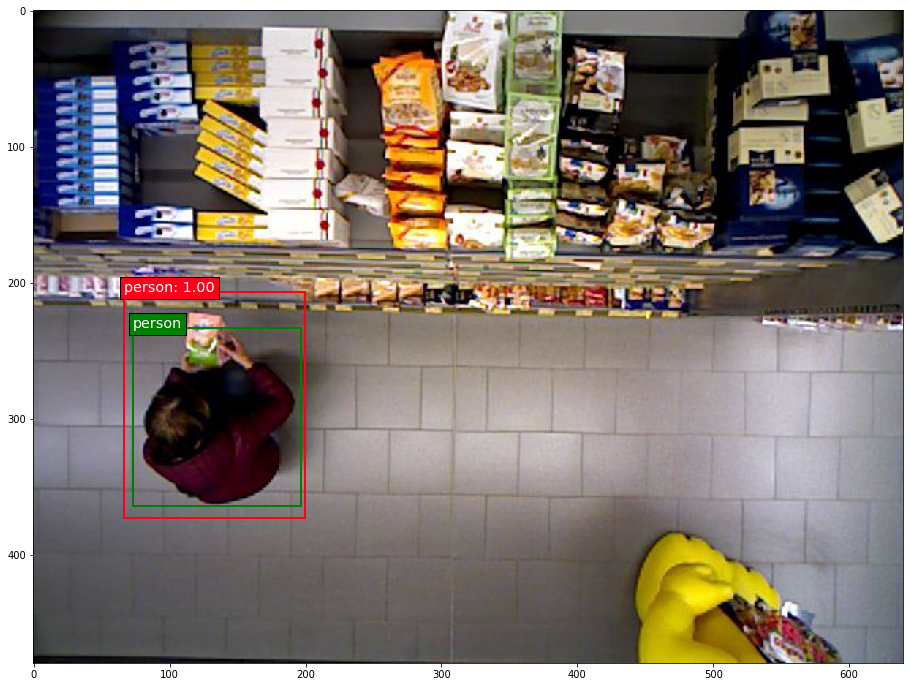

In [36]:
# Display the image and draw the predicted boxes onto it.
# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 2)).tolist()
classes = ['background', 'person']

plt.figure(figsize=(20,12))
plt.imshow(batch_images[i])

current_axis = plt.gca()

for box in batch_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_thresh[i]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})